<h1>An example of Irish Music represented graphically</h1>
<h3>Converting ABC notation into a vectorized form to visually represent the output, with the intention of training machine learning algorithms on the resulting images</h3>
Note, this notebook was created as a simple proof of concept. Proper python modules for cleaning, filtering, and vectorization of the dataset will follow, hopefully with less loss of the original dataset.

In [1]:
# Imports
from Tunes_cleaned import tunes as raw_tunes
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=10) 

In [2]:
tunes = pd.DataFrame.from_dict(raw_tunes, orient='index')

<h2>Data filtering</h2>
We will limit our dataset to only songs in 4/4, with no tuples or non-diatonic notes

In [3]:
tunes_clean = tunes.drop(tunes[tunes['meter']!='4/4'].index)

In [4]:
def remove_remarks(frame):
    """
    Remarks are extraneous information contained in square brackets
    """
    frame['abc'] = frame['abc'].str.replace('\[.*?\]', '')
    return frame

In [5]:
def remove_tuples(frame):
    """
    Tuplets are occurences of irrational time
    """
    return frame.drop(frame[frame['abc'].str.count('\(\d')>0].index)

In [6]:
def remove_non_diatonic(frame):
    """
    Non-diatonic notes are notes not found within the default key signature
    """
    return frame.drop(frame[frame['abc'].str.count('\^|_|=')>0].index)

In [7]:
def remove_small_strings(frame, len):
    """
    Removes all rows below a certain length
    """
    return frame.drop(frame[frame.abc.str.len()<len].index)

In [8]:
def remove_ornamentation(frame):
    """
    Ornamentation represents trills or other performance enhancers
    See http://abcnotation.com/wiki/abc:standard:v2.1#decorations
    .       staccato mark
    ~       Irish roll
    H       fermata
    L       accent or emphasis
    M       lowermordent
    O       coda
    P       uppermordent
    S       segno
    T       trill
    u       up-bow
    v       down-bow
    """
    frame['abc'] = frame['abc'].str.replace("[\.~HLMOPSTuv]",'')
    return frame

In [9]:
def remove_quotations(frame):
    """
    Chord symbols are sypically placed within quotation marks
    """
    frame['abc'] = frame['abc'].str.replace('".*?"', '')
    return frame

In [10]:
def consolidate_barlines(frame):
    """
    Turns all barlines and repeatlines into single '|' characters
    see http://abcnotation.com/wiki/abc:standard:v2.1#repeat_bar_symbols
    """
    frame['abc'] = frame['abc'].str.replace('\|+|\|:|\|[|:\||]\|', '|')
    return frame

<h4>NOTE: This implementation currently ignores repeats entirely.</h4>

In [11]:
tunes_clean = remove_remarks(tunes_clean)
tunes_clean = remove_tuples(tunes_clean) 
tunes_clean = remove_non_diatonic(tunes_clean)
tunes_clean = remove_small_strings(tunes_clean,32)
tunes_clean = remove_ornamentation(tunes_clean)
tunes_clean = remove_quotations(tunes_clean)
tunes_clean = tunes_clean.drop_duplicates(subset='abc')
tunes_clean = consolidate_barlines(tunes_clean) #barlines
tunes_clean['abc'] = tunes_clean['abc'].str.replace(':','') #repeats
tunes_clean['abc'] = tunes_clean['abc'].str.replace('[<>]','') #syncopation
tunes_clean['abc'] = tunes_clean['abc'].str.replace('[-()]','') #ties and slurs

<h2> "Expanding" the songs into 16th notes </h2>
Every note will be represented as a series of 16'th notes. In this implementation no note length data is preserved, meaning there is no functional difference between a quarter note and 4 16'th notes. Obviously this is a significant shortcoming that will be addressed.

In [12]:
def get_rand_songs(frame, num=10):
    songs = frame.sample(n=num)['abc']
    return songs

In [13]:
def split_by_bar(abc_string):
    """
    Takes a string of full ABC notation and splits it into lists representing individual bars
    """
    result = abc_string.split('|')
    return [x for x in result if x != '']

In [14]:
def expand_bar(bar):
    """
    Takes a str representing a single bar of notes (no barlines)
    Returns a string with each 16th note as it's own character
    Note: because of octaves and other random noise bars are NOT guaranteed to be 16 characters
    """
    output = ""
    if len(bar)==0:
        return output
    if bar[0].isnumeric():
        bar = bar[1:]
    #if the bar contains only letters then all letters are of equal length
    if bar.isalpha():
        time_value = 16//len(bar)
        for char in bar:
            output+= char*time_value
        return output
    
    # if the bar contains more timing information, we must parse it
    
    # === Long Notes ===
    # long notes are notes with a number following them, c2 is twice the length of c
    # long notes regex group
    long_notes_re = re.compile('([a-zA-Z],*\'*(\d))')
    long_notes = long_notes_re.findall(bar)
    ### inline func to replace long notes
    def replace_long_notes(note):
        """
        Takes a re match and replaces it with \d occurences of the letter
        """
        str = note.group()[:-1]
        n = int(note.group(2))
        return str*n
    ### endfunc
    if long_notes:
        bar = long_notes_re.sub(replace_long_notes,bar)
        
    # === SHORT NOTES ===
    # short notes are notes with a / and a number, c/2 is half the length of c
    # short notes regex group, group 2 matches a number if it is present
    highest_mult = 2 #default for / in ABC notation is to halve the length
    short_notes_re = re.compile('([a-zA-Z],*\'*)(/)(\d*)')
    short_notes = short_notes_re.findall(bar)
    if short_notes:
        # check if any of the note divisions are higher than the default of 2
        for note, slash, num in short_notes:
            if num.isnumeric and num is not "":
#                 print("{} {} {} {}".format(note,slash,type(num),type(highest_mult)))
                if int(num)>int(highest_mult):
                    highest_mult=int(num)
    # get every non-short note and multiply it by the highest multiple value
    not_short_notes_re = re.compile('[a-zA-Z],*(?!/)')
    not_short_notes = not_short_notes_re.findall(bar)    
    ### inline function to replace notes
    def lengthen_non_short_notes(match_str):
        return match_str.group()*highest_mult
    ### endfunc
    # lengthen all notes that aren't 'short notes'
    bar = not_short_notes_re.sub(lengthen_non_short_notes, bar)
    def replace_short_notation(match_str):
        return match_str.group(1)
    bar = short_notes_re.sub(replace_short_notation, bar)
    #lastly some bars need to be expanded to exactly 16 notes
    #note: this won't fix octave characters as they correspond to 2 characters right now, the same test should be done when the letters are converted to numbers
    if len(bar)!=0 and 16%len(bar)==0:
        new_bar = ""
        time_value = 16//len(bar)
        for char in bar:
            new_bar+= char*time_value
        bar = new_bar
    return bar

<h2>Visualizing some examples</h2>
Let's take a sample of 50 songs and visualize what we can. In this implementation any song that contains bars whos length's are not 16 are discarded entirely. In a proper implementation this will need to be addressed, perhaps through the use of padding.

In [15]:
rand_songs = get_rand_songs(tunes_clean,50)
# uncomment below to see the 'cleaned' representation of 3 random songs
print("Cleaned Song Format:\n")
for song in rand_songs[:3]:
    print(song+'\n')

Cleaned Song Format:

|A,B,DEDEFD|DEFAABA2|fedccBAF|DEFDGFED|A,B,DEDGFD|DEFAABA2|fedgcdAB|1AEFDGFED|2AEFDGABc|dDDDAFEA|dDDDdcBA|dAFGABAF|DEFDGABc|

efedB2B2|efedB2B2|fgafA2d2|fgafA3z|b2gba2fa|g2egf3z|edefgfed|e2ff2g2z2|efedB2B2|efedB2B2|dcBAcBAG|FGAFD2EF|GFGABABd|edefg2e2|dcBABAGF|E3DEFE3z|

A2ABA2dB|ADFABGE2|A2FABdAd|BdAGFDDB|ADFABdcB|A2FABEEF|G3ABdeg|fdecdBAB|d2fdedBd|egfedBAB|d2fdegfe|dBAGFDD2|d2fdedBd|egfedBAB|defga2ag|faegfdd2|



In [16]:
songs_clean = []
for song in rand_songs:
    song_split = split_by_bar(song)
    bars = []
    for bar in song_split:
        bars.append(expand_bar(bar))
    for bar in bars:
        if (len(bar)) is not 16:
            pass
#             print("{}: {}".format(len(bar),bar))
    songs_clean.append(bars)
    
# uncomment below to see the format of 3 random songs after the bars have been 'expanded'
print("Expanded Song Format:\n")
for n in range(3):
    print("{}\n".format(random.choice(songs_clean)))

Expanded Song Format:

['ffffffffffffffff', 'eeBBBBBBeeBBddBB', 'AAAAGGAABBddddgg', 'eeBBBBBBeeBBddBB', 'AABBGGAABBGGGGGG', 'eeBBBBBBeeBBddBB', 'AAAAGGAABBGGGGFF', 'GGGGBBddeeggddBB', 'AABBGGAABBGGGG', 'zzzzzzzzzzzzzzzz', 'ggbbaaggeeggddgg', 'bbggaaggeeaaaaaa', 'ggbbaaggeeggddBB', 'AABBGGAABBGGGGGG', 'ggbbaaggeeggddgg', 'bbggaaggeeaaaaaa', 'ggggffggeeggddBB', 'AABBGGAABBGGGG']

['DDDDDDDDDDDDDDDD', 'AAFFA,A,A,A,AAAAGGFF', 'FFFF{GGFF}EEDDFFFF{GGFF}EEEE', 'DDDDddccBBBBBBAA', 'AAAADDEEFFFF{GGFF}EEEE', 'AAFFA,A,A,A,AAAAGGFF', '{GG}FFFF{GGFF}EEDD{GG}FFFF{GGFF}EEEE', 'DDDDBB{BBcc}AAAAAADDEE', 'FFFFEEDDDDDDDDDD', 'DDDDDDDDDDDDDDDD', 'ddddccddeeeeeecc', 'ddddccdd{FFGG}FFFFFFFF', 'ddddccddBBBB{BB}AABB', 'AAAADDEEFFFF{GGFF}EEEE', 'ddddccddeeeeeecc', 'ddddccddFFFFFFEE', 'DDDDBBAAAAAADDEE', 'FFFFEEDDDDDDDDDD', 'ddddccddeeeeeecc', 'ddddccdd{FFGG}FFFFFFFF', 'ddddccddBBBB{BB}AABB', 'AAAADDEEFFFF{GGFF}EEEE', 'AAFFA,A,A,A,AAAAGGFF', 'FFFFEEDDFFFF{GGFF}EEEE', 'DDDDBBAAAAAADDEE', 'FFFF{FF}EEDDDDDDDDDD', 

In [17]:
def abc_to_notelist(abc):
    result = []
    bars = split_by_bar(abc)
    for bar in bars:
        result.append(expand_bar(bar))
    return result

In [18]:
tunes_vectorized = tunes_clean['abc'].apply(abc_to_notelist)

In [19]:
notes = {
    'C' : 60,
    'D' : 61,
    'E' : 62,
    'F' : 63,
    'G' : 64,
    'A' : 65,
    'B' : 66,
    'c' : 67,
    'd' : 68,
    'e' : 69,
    'f' : 70,
    'g' : 71,
    'a' : 72,
    'b' : 73
}

def abc_to_nums(abc):
    """
    Converts a single bar to note numbers
    """
    nums = []
    for letter in abc:
        if letter in notes:
            nums.append(notes[letter])
        elif len(nums)==0:
            continue
        elif letter is "'":
            nums[-1]+=7
        elif letter is ",":
            nums[-1]-=7     
    return np.asarray(nums)

In [20]:
# takes a random sample of the songs and rejects if if it's not of size (n>16,16)
while(True):
    song_sample = tunes_vectorized.sample(1).iloc[0]
#     print(song_sample)
    song_nums = []
    for bar in song_sample:
        song_nums.append(abc_to_nums(bar))
    song_nums = np.asarray(song_nums)
    if song_nums.shape[0]<16:
        continue
    if len(song_nums.shape)==2 and song_nums.shape[1]==16:
        break
# restrict to first 16 bars
song_nums = song_nums[:16]

In [21]:
def print_img_by_bars(songs, numcols=3):
    """
    Takes an array of arrays of size 16,16 and plots it in 3 configurations
    """
    f, axs = plt.subplots(len(songs),numcols,figsize=(10,len(songs)*2))
    plt.tight_layout()
    for num, song in enumerate(songs):
        img = song[:16]
        index = num*numcols+1
        plt.subplot(len(songs), 3, index)
        plt.axis('off')
        plt.title("1 bar per line", fontsize=10)
        plt.matshow(img, cmap='gray', interpolation='nearest', fignum=0, aspect="auto")
        plt.subplot(len(songs), 3, index+1)
        plt.axis('off')
        plt.title("2 bars per line", fontsize=10)
        plt.matshow(img.reshape(8,32), cmap='gray', interpolation='nearest', fignum=0, aspect="auto")
        plt.subplot(len(songs), 3, index+2)
        plt.axis('off')
        plt.title("4 bars per line", fontsize=10)
        plt.matshow(img.reshape(4,64), cmap='gray', interpolation='nearest', fignum=0, aspect="auto")


<h3>Let's take some random samples and plot the results</h3>
Note: sample size is not the final size of the visualized output. Any songs with fewer than 16 bars or with a single bar of a size other than 16 are rejected.

In [22]:
song_samples = tunes_vectorized.sample(50)
songs_as_nums = []
for song in tunes_vectorized:
    numsong = []
    for bar in song:
        numsong.append(abc_to_nums(bar))
    numsong = np.asarray(numsong)
    if numsong.shape[0]<16:
        continue
    elif len(numsong.shape)==2 and numsong.shape[1]==16:
        songs_as_nums.append(numsong)
songs_as_nums = np.asarray(songs_as_nums)

In [23]:
# uncomment to save all the songs to disk.
# songs_as_nums = []
# for song in tunes_vectorized:
#     numsong = []
#     for bar in song:
#         numsong.append(abc_to_nums(bar))
#     numsong = np.asarray(numsong)
#     if numsong.shape[0]<16:
#         continue
#     elif len(numsong.shape)==2 and numsong.shape[1]==16:
#         songs_as_nums.append(numsong)
# songs_as_nums = np.asarray(songs_as_nums)
# np.save('vectorized_songs',songs_as_nums)


In [24]:
# uncomment to see the vector form of 3 random songs
print("Vectorized Song Format:\n")
for n in range(3):
    print("{}\n".format(np.random.choice(songs_as_nums)))

Vectorized Song Format:

[[60 60 62 62 62 62 62 62 64 64 65 65 64 64 62 62]
 [61 61 68 68 68 68 67 67 68 68 68 68 67 67 65 65]
 [64 64 67 67 62 62 67 67 64 64 65 65 67 67 72 72]
 [71 71 69 69 68 68 71 71 69 69 67 67 67 67 67 67]
 [60 60 60 60 60 60 62 62 64 64 65 65 64 64 62 62]
 [61 61 68 68 68 68 67 67 68 68 67 67 65 65 67 67]
 [64 64 67 67 62 62 67 67 64 64 65 65 67 67 72 72]
 [71 71 69 69 68 68 71 71 69 69 67 67 67 67 66 66]
 [67 67 67 67 69 69 67 67 71 71 67 67 69 69 67 67]
 [67 67 68 68 69 69 72 72 71 71 69 69 68 68 69 69]
 [67 67 67 67 69 69 67 67 71 71 67 67 69 69 67 67]
 [64 64 65 65 67 67 71 71 69 69 67 67 67 67 66 66]
 [67 67 67 67 69 69 67 67 71 71 67 67 69 69 67 67]
 [67 67 68 68 69 69 72 72 71 71 69 69 68 68 71 71]
 [67 67 68 68 67 67 65 65 64 64 65 65 67 67 72 72]
 [71 71 69 69 68 68 71 71 69 69 67 67 67 67 67 67]]

[[62 62 65 65 65 65 64 64 65 65 65 65 65 65 66 66]
 [67 67 68 68 69 69 68 68 67 67 66 66 65 65 67 67]
 [66 66 64 64 64 64 64 64 68 68 64 64 64 64 64 64]
 [66

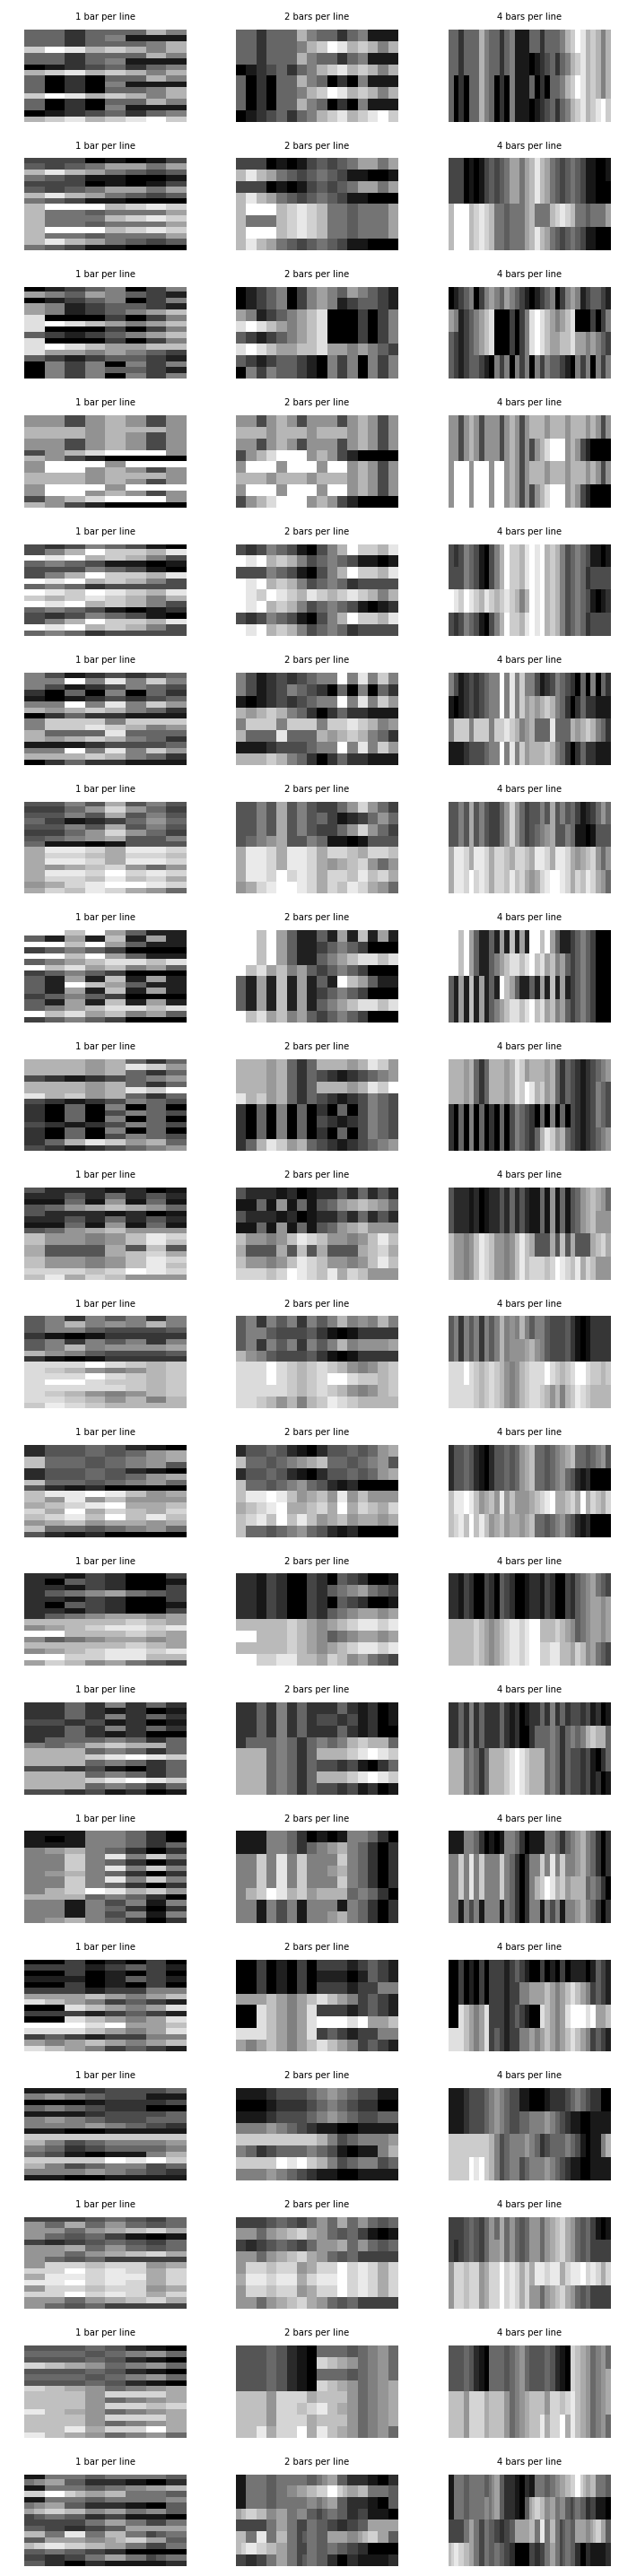

In [25]:
print_img_by_bars(songs_as_nums[:20])
# uncomment below to save as an image
#plt.savefig('bars.png')